In [7]:
from helper import *
from Agent import *

In [8]:
# Hyperparameters
gamma = 0.9
nb_trials = 100
nb_episodes = 500
learning_rate = 0.01
eps = 1e-7
beta_v = 0.05
beta_e = 0

# Prepare

In [9]:
rail_generator = sparse_rail_generator(max_num_cities=10)

env = RailEnv(
    width=30, 
    height=30, 
    number_of_agents=1,
    rail_generator=rail_generator,
    line_generator=sparse_line_generator(),
    obs_builder_object=GlobalObsForRailEnv(),
    )
obs = env.reset()
while True:
    obs, rew, done, info = env.step({
            0: np.random.randint(0, 5),
            1: np.random.randint(0, 5)
        })
    if done:
        break

In [10]:
# Save Paths
path = "train/" + datetime.now().strftime("%m%d-%H:%M:%S")
log_dir = path+'/logs/'
ckpt_dir = path+'/ckpt/'
train_summary_writer = tf.summary.create_file_writer(log_dir)

In [11]:
agent = LSTMAgent(learning_rate, gamma, beta_v, beta_e,  #loss func
                 env, nb_trials, nb_episodes,path,
                 nb_hidden = 256)

# Train

In [12]:
agent_id = 0

agent.train()

KeyboardInterrupt: 

In [ ]:
def run_episode(env):
    next_obs, _ = env.reset()
    print(env.agents[0].earliest_departure)
    print(env.agents[0].latest_arrival)
    score = 0
    reward = 0.0
    action_onehot = np.zeros((agent.nb_actions))
    cell_state = [tf.zeros((1,agent.nb_hidden)),tf.zeros((1,agent.nb_hidden))]
        
    for timestep in range(100):
        input = agent.prepare_input(next_obs, agent_id, action_onehot,reward,timestep)
        
        action_probs, critic_value, cell_state = agent.model([input,cell_state[0],cell_state[1]])
        
        action_probs = tf.squeeze(action_probs)
        action = np.random.choice(agent.nb_actions, p=action_probs.numpy())
        action_onehot = np.zeros((agent.nb_actions))
        action_onehot[action] = 1

        next_obs, all_rewards, dones, _ = env.step({agent_id: action})

        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]

        render_env(env)
        print('Timestep {}, action = {}, total score = {}'.format(timestep, action_map[action], score))
        tf.print(action_probs)

        if dones['__all__']:
            print('All done!')
            return

    print("Episode didn't finish after 100 timesteps.")

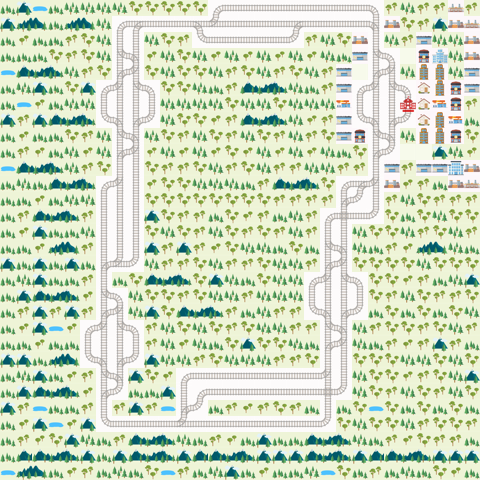

Timestep 1, action = nothing, total score = 0
[0.999959826 2.29687453e-06 6.37277253e-09 3.70726848e-05 7.94810319e-07]


KeyboardInterrupt: 

In [ ]:
run_episode(env)